In [ ]:
import subprocess
commands = "kaggle datasets download -d chrisfilo/urbansound8k"
subprocess.run(commands.split(" "))

In [11]:
import os
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
import pickle


### Data Augmentation

In [36]:
def augement_audio(sample_file, sampling_rate):
    '''
    add noise to the audio sample with audioentations

    parameters:
    sample_file -- np array of audio file (loaded in with librosa)
    sampling_rate -- sampling rate given by librosa upon load
    
    returns augmented data
    '''
    augment = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        TimeStretch(min_rate=0.5, max_rate=1.5, p=0.5),
        PitchShift(min_semitones=-5, max_semitones=5, p=0.5),
        Shift(p=0.5),
    ])
    return augment(samples=sample_file, sample_rate=sampling_rate)

os.chdir(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\original")
for root, dirs, files in os.walk("."):  
    for file in files:
        folder = os.path.basename(root)
        relative_path = os.path.join(folder, file)
        sample_file, sampling_rate = librosa.load(relative_path)
        augmented_data = augement_audio(sample_file, sampling_rate)
        output_folder = os.path.join(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\augmented", os.path.basename(folder))
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        output_path = os.path.join(output_folder, file)
        sf.write(output_path, augmented_data, sampling_rate, subtype='PCM_24')  


c:\Users\proba\anaconda3\envs\gen-ai-audio-enhance\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\proba\anaconda3\envs\gen-ai-audio-enhance\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\proba\anaconda3\envs\gen-ai-audio-enhance\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


### Example Spectrogram

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

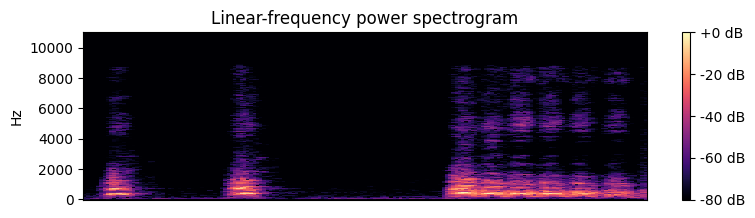

In [16]:
# Augment/transform/perturb the audio data
D = librosa.amplitude_to_db(np.abs(librosa.stft(augmented_samples)), ref=np.max)
plt.figure(figsize=(20,10))

plt.subplot(4,2,1)

librosa.display.specshow(D, y_axis='linear')

plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

### Data Preprocessing

In [38]:
def preprocess_audio(relative_path):
    '''
    process audio by normailzing volume and apply pre-emphasis filter
    parameters:
    relative_path -- path to file
    
    returns processed data 
    '''
    (y,sr) = librosa.load(relative_path,mono=False) #standardize sample rate
    #(-32768, 32767)
    #()
    #(y,sr) = librosa.load(out_file,sr=44100,mono=False) 
    max_peak = np.max(np.abs(y)) 
    ratio = 8388607 / max_peak 
    y = y * ratio
    y_filt = librosa.effects.preemphasis(y)
    return y_filt

os.chdir(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\augmented")
for root, dirs, files in os.walk("."):  
    for file in files:
        folder = os.path.basename(root)
        relative_path = os.path.join(folder, file)
        processed_data = preprocess_audio(relative_path)
        output_folder = os.path.join(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\processed", os.path.basename(folder))
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        output_path = os.path.join(output_folder, file)
        sampling_rate = 16000 #adjust sampling rate on save
        sf.write(output_path, processed_data, sampling_rate, subtype='PCM_24')

### Feature Extraction

In [13]:
def extract_features(relative_path):
    '''
    process audio by normailzing volume and apply pre-emphasis filter
    parameters:
    relative_path -- path to file
    
    returns processed data 
    '''
    (y,sr) = librosa.load(relative_path) #standardize sample rate
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return spectrogram, mfccs


csv_data = pd.read_csv(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\UrbanSound8K.csv")
class_dict = dict(zip(csv_data.slice_file_name, csv_data.classID))
os.chdir(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\processed")

for root, dirs, files in os.walk("."): 
    folder = os.path.basename(root)
    spectrograms = []
    mfccs_list = []
    for file in files:
        relative_path = os.path.join(folder, file)
        spect, mfccs = extract_features(relative_path)
        fileclass = class_dict.get(file)

        newdict1 = {'file':file,
                   'fold':folder,
                   'class':fileclass,
                   'spectrogram':spect}
        
        spectrograms.append(newdict1)

        newdict2 = {'file':file,
                   'fold':folder,
                   'class':fileclass,
                   'mfccs':mfccs}
        
        mfccs_list.append(newdict2)

    if "fold" in folder:
        output_folder = os.path.join(r"C:\Users\proba\OneDrive\Documents\Booz Training\generative-ai-audio-enhancement-classification\data\features", os.path.basename(folder))
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        output_path = os.path.join(output_folder, "spectrograms.pickle")
        output_path2 = os.path.join(output_folder, "mfccs.pickle")
        with open(output_path, 'wb') as f:
            pickle.dump(spectrograms, f)
        with open(output_path2, 'wb') as f:
            pickle.dump(mfccs_list, f)



c:\Users\proba\anaconda3\envs\gen-ai-audio-enhance\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1521
  warnings.warn(
c:\Users\proba\anaconda3\envs\gen-ai-audio-enhance\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1824
  warnings.warn(


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
